In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from dolfin import *

In [107]:
class ReparametrizedExpression(UserExpression):
    def __init__(self, f: Expression, phi, **kwargs):
        self.f = f
        self.phi = phi
        super().__init__(**kwargs)
        
    def eval(self, value, x):
        value[0] = self.f(self.phi(x[0]))
        
    def value_shape(self):
        return ()
    

class ReparametrizedPoissonSource(UserExpression):
    def __init__(self, f: Expression, phi, dV: FunctionSpace, **kwargs):
        self.f = f
        self.phi = phi
        self.dphi = project(phi.dx(0), dV)
        super().__init__(**kwargs)
        
    def eval(self, value, x):
        value[0] = self.dphi(x[0])**2 * self.f(self.phi(x[0]))
        
    def value_shape(self):
        return ()

    
# def solve_poisson_neumann(V, f, phi):
#     # Build function space with Lagrange multiplier
#     P1 = FiniteElement("Lagrange", mesh.ufl_cell(), 1)
#     R = FiniteElement("Real", mesh.ufl_cell(), 0)
#     W = FunctionSpace(mesh, P1 * R)
    
#     # Define variational problem
#     (u, c) = TrialFunctions(W)
#     (v, d) = TestFunctions(W)
    
# #     phi = project(phi, W.sub(0).collapse())
#     gphi = ReparametrizedExpression(f, phi, degree=3)
    
#     a = (inner(grad(u), grad(v)) + c*v + u*d)*dx
#     L = (Dx(phi, 0) * Dx(phi, 0)) * gphi * v * dx  + Constant(0.)*v * ds
        
#     A = assemble(a)
#     b = assemble(L)
        
#     u = Function(W)
#     solve(A, u.vector(), b)
#     return u
    

def solve_poisson(V, f, phi, dirichlet_bcs):
    P1 = FunctionSpace(mesh, "CG", 1)
    P2 = FunctionSpace(mesh, "CG", 2)
    P3 = FunctionSpace(mesh, "CG", 3)

    u = TrialFunction(V)
    v = TestFunction(V)
    gphi = ReparametrizedPoissonSource(f, phi, P3)
    dphi = project(phi.dx(0), P3)
    ddphi = project(phi.dx(0).dx(0), P3)
    
    a = u.dx(0) * v.dx(0) * dx  + ddphi / dphi * u.dx(0) * v * dx
    L = gphi * v * dx
    
    A = assemble(a)
    b = assemble(L)
    
    for bc in dirichlet_bcs:
        bc.apply(A, b)
        
    u = Function(V)
    solve(A, u.vector(), b)
    return u


def plot_curve(f, ax=None, N=401, **kwargs):
    if ax is None:
        ax = plt.gca()
    x = np.linspace(-1, 1, N)
    return ax.plot(x, [f(xi) for xi in x], **kwargs)

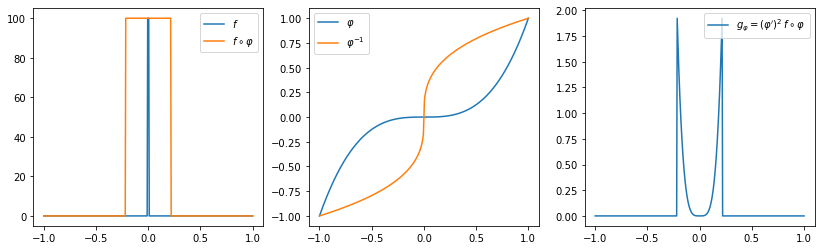

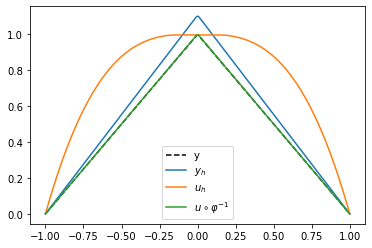

In [108]:
mesh = IntervalMesh(2**9, -1, 1)
P1 = FunctionSpace(mesh, "CG", 1)
P2 = FunctionSpace(mesh, "CG", 2)
P3 = FunctionSpace(mesh, "CG", 3)

# Define Source
a = 0.01
f = Expression("abs(x[0]) <= a ? 1.0 / a : 0.", degree=0, a=a)

# Define various reparametrizations
identity = Expression("x[0]", degree=3, domain=mesh) # id(x) = x
phi = Expression("pow(x[0], 3)", degree=3, domain=mesh)
phi_inv = Expression("std::cbrt(x[0])", degree=5, domain=mesh)

# Define reparametrized version of source
fphi = ReparametrizedExpression(f, phi, degree=3)
gphi = ReparametrizedPoissonSource(f, phi, P2, degree=3)
gphi_analytic = Expression("abs(x[0]) < std::cbrt(a) ? (9 / a) * pow(x[0], 4) : 0.",degree=4, a=a, domain=mesh)

y_analytic = Expression(
    "abs(x[0]) < a ? (1. - 0.5*a) - 0.5 / a * x[0]*x[0] : (x[0] < 0. ? 1 + x[0] : 1 - x[0])",
    a = a, degree=2)


# Do plotting
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 4))

plot_curve(f, ax=ax1, label=r"$f$")
plot_curve(fphi, ax=ax1, label=r"$f\circ\varphi$")

plot_curve(phi, ax=ax2, label=r"$ \varphi$")
plot_curve(phi_inv, ax=ax2, label=r"$ \varphi^{-1}$")

plot_curve(gphi, ax=ax3, label=r"$g_\varphi = (\varphi')^2 \, f\circ\varphi$")
# plot_curve(gphi_analytic, ax=ax3)

ax1.legend()
ax2.legend()
ax3.legend()
plt.savefig("../figures/example1_sources.png")
plt.show()


# Solve
bcs = [DirichletBC(P1, Constant(0.), "on_boundary")]
yh = solve_poisson(P1, f, identity, bcs)
uh = solve_poisson(P1, f, phi, bcs)
u_phiinv = ReparametrizedExpression(uh, phi_inv)

plt.figure()
plot_curve(y_analytic, ls='--', color="k", label="y")
plot_curve(yh, label="$y_h$")
plot_curve(uh, label="$u_h$")
plot_curve(u_phiinv, label=r"$u\circ\varphi^{-1}$")
plt.legend()
plt.savefig("../figures/example1_results_mesh512.png")
plt.show()